#Chisholm / Prochlorococcus project
##Use Python and its various libraries to link the KEGG compound information with pathways
###KLongnecker, 4/17/2017

In [8]:
import pandas as pd
import numpy as np
import re
import os
import glob

import palettable as pal
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['pdf.fonttype'] = 42

from Bio import SeqIO
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
from IPython.display import Image, HTML

#used this to step into the function and debug it, also need line with Tracer()() 
from IPython.core.debugger import Tracer 
#os._exit(1) #this should get me out of the debugging...

%matplotlib inline

In [9]:
mtabFile = 'ChisholmPro_KEGGexport.2017.04.17.csv' #first column is KEGG C number

In [10]:
mtabData=pd.read_csv(mtabFile, index_col='KEGG')

In [11]:
mtabData.head()

,Plimited_extracellular_s9301ax_50,Plimited_filter_s9301ax_50,replete_extracellular_s9301ax_10,replete_extracellular_s9301ax_50,replete_extracellular_s0801ax_10,replete_extracellular_s9313ax_5,replete_extracellular_s9313ax_10,replete_filter_s9301ax_10,replete_filter_s9301ax_50,replete_filter_s0801ax_10,replete_filter_s9313ax_5,replete_filter_s9313ax_10
KEGG,,,,,,,,,,,,
C00196,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
C19675,59.673373,0.0,541.630502,0.000000,399.057861,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
C08276,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
C00141,8169.547758,0.0,16449.808476,24651.926818,223.180717,100228.888379,116396.989909,0.000000,0.000000,0.000000,0.00000,0.000000
C00671,0.000000,0.0,5910.269185,13236.046283,0.000000,20150.069568,26468.359973,316.366725,303.627647,272.686725,19.57057,395.492424


In [12]:
#Picking code out of the NB project

In [13]:
allPathways = kegg_list("pathway").read()
len(allPathways.split('\n'))
#number here is the # of pathways at KEGG, up to 486 by 4/13/2016; and 513 one year later on 4/17/2017

513

In [14]:
trimPath = []
current_section = None
for line in allPathways.rstrip().split("\n"):
    tp = line[8:13]
    trimPath.append('ko' + tp)
    
#have some cases where KEGG will send back a pathway, but the pathway itself is not searchable...seems to 
#be a KEGG bug, 'ko00351' was first, then realized there are many of these,
#did this list manually since I thought it would be short...
toDelete = ('ko00351', 'ko01010','ko01060',  'ko01061', 'ko01062', 'ko01063', 
            'ko01064', 'ko01065', 'ko01066', 'ko01070', 'ko07011', 'ko07012', 
            'ko07013', 'ko07014', 'ko07015', 'ko07016', 'ko07017', 'ko07018', 
            'ko07019', 'ko07020', 'ko07021', 'ko07023', 'ko07024', 'ko07025', 
            'ko07026', 'ko07027', 'ko07028', 'ko07029', 'ko07030', 'ko07031', 
            'ko07032', 'ko07033', 'ko07034', 'ko07035', 'ko07036', 'ko07037', 
            'ko07038', 'ko07039', 'ko07040', 'ko07041', 'ko07042', 'ko07043', 
            'ko07044', 'ko07045', 'ko07046', 'ko07047', 'ko07048', 'ko07049', 
            'ko07050', 'ko07051', 'ko07052', 'ko07053', 'ko07054', 'ko07055', 
            'ko07056', 'ko07057', 'ko07110', 'ko07112', 'ko07114', 'ko07117', 
            'ko07211', 'ko07212', 'ko07213', 'ko07214', 'ko07215', 'ko07216', 
            'ko07217', 'ko07218', 'ko07219', 'ko07220', 'ko07221', 'ko07222', 
            'ko07223', 'ko07224', 'ko07225', 'ko07226', 'ko07227', 'ko07228', 
            'ko07229', 'ko07230', 'ko07231', 'ko07232', 'ko07233', 'ko07234', 
            'ko07235', 'ko04933')

#probably a way to do this without the for loop, but this will work
for item in toDelete:
    trimPath.remove(item)

In [15]:
#setup some functions

In [16]:
#set up a function to get the list of compounds for a given pathway (must be defined as ko00140 NOT map00140)
def getCfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    compound_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "COMPOUND":
            compound_identifiers = line[12:].split("; ")
            t = compound_identifiers[0]
            compound_id = t[0:6]

            if not compound_id in compound_list:
                compound_list.append(compound_id)
    return compound_list

In [17]:
#set up a function to get the list of K orthologues for a given pathway (must be defined as ko00140 NOT map00140)
#for this project: can use the three digit code for the different Prochlorococcus strains
def getKfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    K_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "ORTHOLOGY":
            K_identifiers = line[12:].split("; ")
            t = K_identifiers[0]
            K_id = t[0:6]

            if not K_id in K_list:
                K_list.append(K_id)
    return K_list

In [18]:
# A bit of code that will help us display the PDF output
def PDF(filename):
    return HTML('<iframe src=%s width=700 height=350></iframe>' % filename)

In [19]:
## A bit of helper code to shorten long text
#def head(text, lines=10):
#    """ Print the first lines lines of the passed text.
#    """
#    print '\n'.join(text.split('\n')[:lines] + ['[...]'])

In [20]:
out = getKfrom_ko('pmg00230')

In [21]:
item = 'pmg00230'

In [22]:
useColors = pal.colorbrewer.qualitative.Set1_4.hex_colors

In [23]:
pathway = KGML_parser.read(kegg_get(item, "kgml"))

In [24]:
pathway

In [25]:
canvas = KGMLCanvas(pathway, import_imagemap=True)
pdfName = 'mapWithColors_' + str(item) + '.pdf'
#canvas.draw(directoryPDF + '/' + pdfName)
canvas.draw(pdfName)
PDF(pdfName)

In [43]:
# import fxn_plotPathway
##if I make a change, have to reload the function:
from imp import reload
reload(fxn_plotPathway)

<module 'fxn_plotPathway' from 'C:\\Users\\krista\\Documents\\GitHub\\Chisholm_Pro\\fxn_plotPathway.py'>

In [27]:
item

'pmg00230'

In [72]:
#need the KEGG numbers from mtabData (the index)

In [29]:
mtabData.index

Index(['C00196', 'C19675', 'C08276', 'C00141', 'C00671', 'C00568', 'C00156',
       'C00233', 'C00170', '0', 'C00352', 'C04022', 'C00334', 'C01279',
       'C00004', 'C00134', '0', 'C00147', 'C00212', 'C00020', 'C00026',
       'C00062', 'C00049', 'C00719', 'C00120', 'C07481', 'C01674', '0',
       'C00114', 'C03557', 'C00158', 'C00327', 'C08230', 'C00380', 'C01909',
       'C00111', 'C06231', 'C00504', 'C06454', 'C00122', 'C00092', 'C00025',
       'C00064', 'C01705', 'C00242', 'C00387', '0', 'C00954', 'C00294',
       'C00130', 'C00407', 'C00097', 'C00051', 'C00328', 'C00123', '0',
       'C00149', 'C00073', 'C06470', 'C00140', 'C00624', 'C02713', 'C00077',
       'C00295', 'C00864', 'C00079', 'C00074', 'C05786', 'C00148', 'C00314',
       'C00255', '0', 'C00019', 'C00019', 'C00213', 'C00065', 'C00093',
       'C05122', '0', 'C00042', 'C10833', 'C00245', 'C00378', 'C01081',
       'C00188', 'C00214', 'C00398', 'C00078', 'C00106', 'C00105', 'C00183',
       'C00385', 'C01762'],
      

In [30]:
#need to delete the zeros for now...

In [31]:
mtabPruned = mtabData.drop(['0'])

In [32]:
mtabPruned.index

Index(['C00196', 'C19675', 'C08276', 'C00141', 'C00671', 'C00568', 'C00156',
       'C00233', 'C00170', 'C00352', 'C04022', 'C00334', 'C01279', 'C00004',
       'C00134', 'C00147', 'C00212', 'C00020', 'C00026', 'C00062', 'C00049',
       'C00719', 'C00120', 'C07481', 'C01674', 'C00114', 'C03557', 'C00158',
       'C00327', 'C08230', 'C00380', 'C01909', 'C00111', 'C06231', 'C00504',
       'C06454', 'C00122', 'C00092', 'C00025', 'C00064', 'C01705', 'C00242',
       'C00387', 'C00954', 'C00294', 'C00130', 'C00407', 'C00097', 'C00051',
       'C00328', 'C00123', 'C00149', 'C00073', 'C06470', 'C00140', 'C00624',
       'C02713', 'C00077', 'C00295', 'C00864', 'C00079', 'C00074', 'C05786',
       'C00148', 'C00314', 'C00255', 'C00019', 'C00019', 'C00213', 'C00065',
       'C00093', 'C05122', 'C00042', 'C10833', 'C00245', 'C00378', 'C01081',
       'C00188', 'C00214', 'C00398', 'C00078', 'C00106', 'C00105', 'C00183',
       'C00385', 'C01762'],
      dtype='object', name='KEGG')

In [33]:
justKEGG = mtabPruned.index

In [44]:
if True: 
    folder = 'pathway_plots'
    usePathway = item
    useCO = mtabPruned.index
    gc_regular = fxn_plotPathway.gatherDetails(usePathway,folder,useCO,justKEGG)

AttributeError: 'str' object has no attribute 'image'

In [7]:
item

NameError: name 'item' is not defined

In [70]:
#only one pathway at a time
usePathway = item
genes = getKfrom_ko(item)
compounds = getCfrom_ko(item)

In [87]:
#have to track genes and compounds differently for the biopython plotting later on 
setG = set(genes)
setC = set(compounds)
setT = set(justKEGG)
#figure out which compounds are in the TSQ data...
intCompounds = setC.intersection(setT)

In [88]:
intCompounds

{'C00020',
 'C00064',
 'C00130',
 'C00147',
 'C00212',
 'C00242',
 'C00294',
 'C00385',
 'C00387',
 'C01762'}

In [90]:
mtabPruned.head()


,Plimited_extracellular_s9301ax_50,Plimited_filter_s9301ax_50,replete_extracellular_s9301ax_10,replete_extracellular_s9301ax_50,replete_extracellular_s0801ax_10,replete_extracellular_s9313ax_5,replete_extracellular_s9313ax_10,replete_filter_s9301ax_10,replete_filter_s9301ax_50,replete_filter_s0801ax_10,replete_filter_s9313ax_5,replete_filter_s9313ax_10
KEGG,,,,,,,,,,,,
C00196,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
C19675,59.673373,0.0,541.630502,0.000000,399.057861,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
C08276,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
C00141,8169.547758,0.0,16449.808476,24651.926818,223.180717,100228.888379,116396.989909,0.000000,0.000000,0.000000,0.00000,0.000000
C00671,0.000000,0.0,5910.269185,13236.046283,0.000000,20150.069568,26468.359973,316.366725,303.627647,272.686725,19.57057,395.492424


In [92]:
CO_values = mtabPruned.loc[:,'Plimited_extracellular_s9301ax_50']

In [93]:
CO_values.head()

KEGG
C00196       0.000000
C19675      59.673373
C08276       0.000000
C00141    8169.547758
C00671       0.000000
Name: Plimited_extracellular_s9301ax_50, dtype: float64

In [94]:
pathway = KGML_parser.read(kegg_get(usePathway, "kgml"))

In [ ]:
for element in pathway.orthologs:
    Tracer()()
    print(element.name)

> <ipython-input-99-deb057f9476f>(3)<module>()
      1 for element in pathway.orthologs:
      2     Tracer()()
----> 3     print(element.name)

ipdb> element.name
'ko:K00106'
ipdb> element.graphics
ipdb> element.graphics[0]
ipdb> tg = elemenent.name[3:9]
*** NameError: name 'elemenent' is not defined
ipdb> tg = element.name[3:9]
ipdb> tg
'K00106'
ipdb> tg in intGenes
*** NameError: name 'intGenes' is not defined
ipdb> tg in setG
False
ipdb> graphic.bgcolor = useColors[3]
*** NameError: name 'graphic' is not defined
ipdb> quit
ko:K00106
> <ipython-input-99-deb057f9476f>(2)<module>()
      1 for element in pathway.orthologs:
----> 2     Tracer()()
      3     print(element.name)

ipdb> ecit 
*** NameError: name 'ecit' is not defined
ipdb> quit
ko:K14977
> <ipython-input-99-deb057f9476f>(3)<module>()
      1 for element in pathway.orthologs:
      2     Tracer()()
----> 3     print(element.name)

ipdb> ecit
*** NameError: name 'ecit' is not defined
ipdb> exit
ko:K02083
> <ipython-input-9

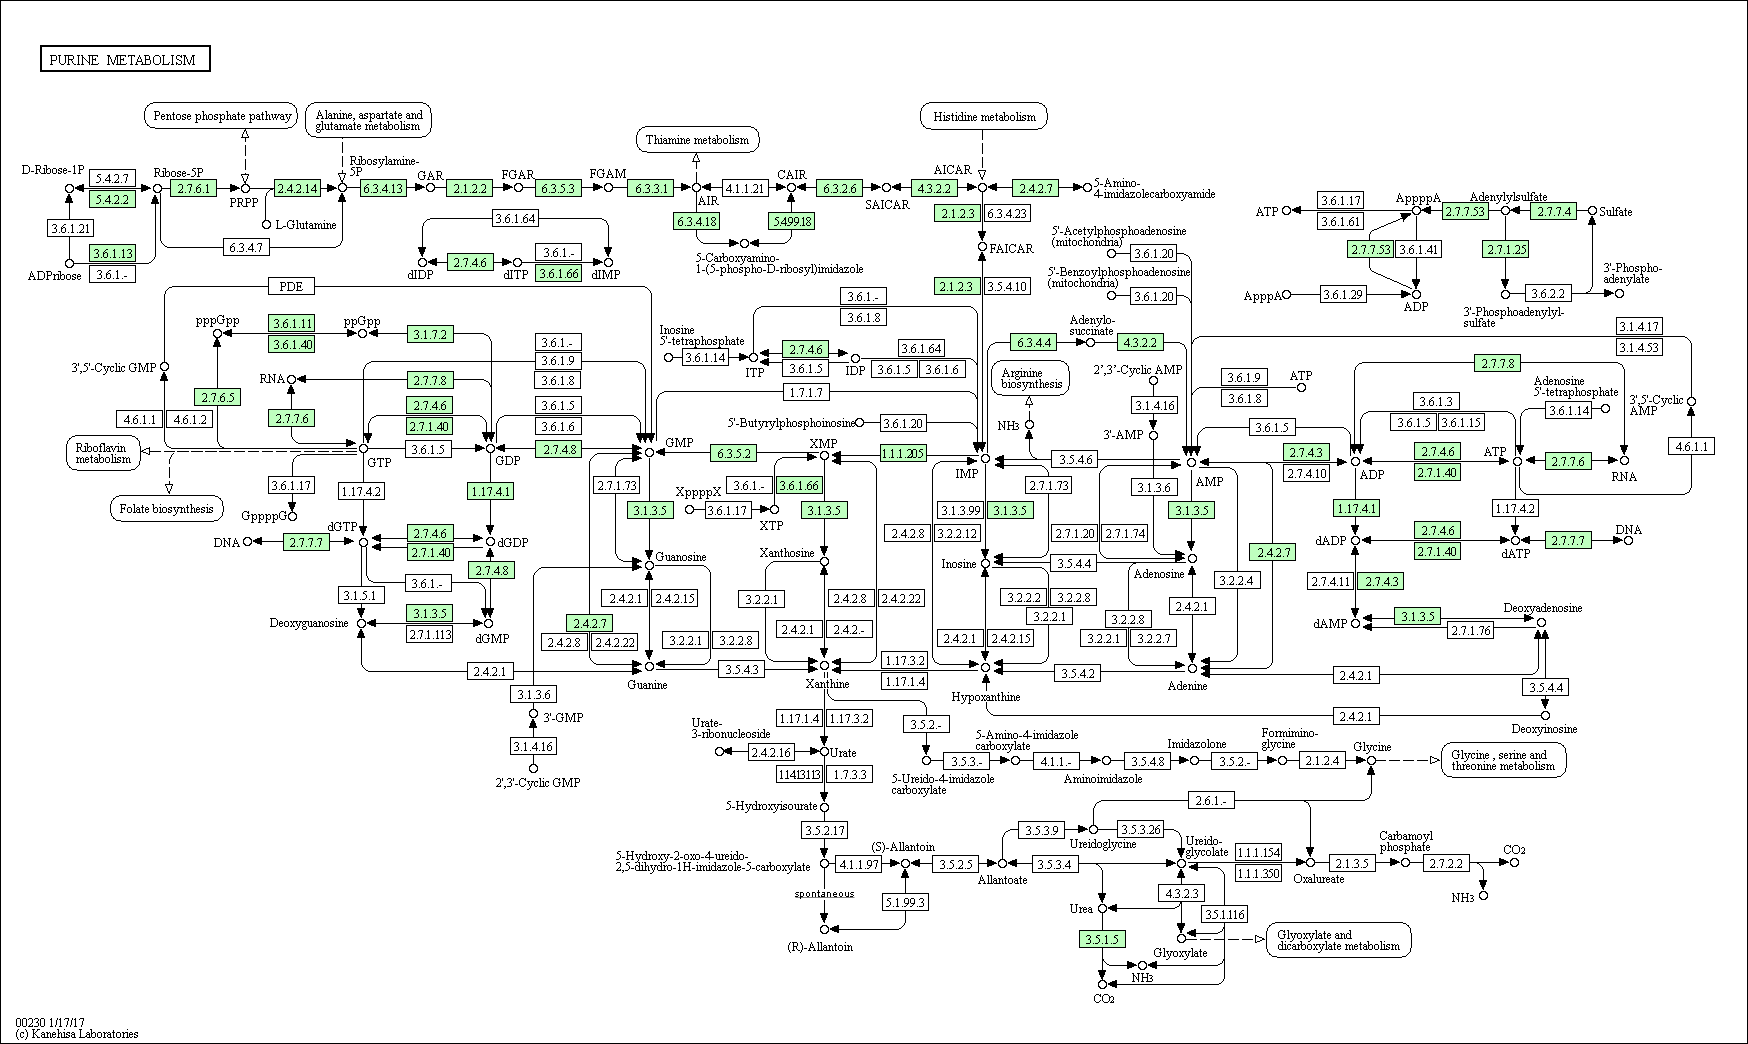

In [55]:
Image(kegg_get('pmg00230','image').read())

In [53]:
kegg_list('pathway','pmg').read()

'path:pmg00010\tGlycolysis / Gluconeogenesis - Prochlorococcus marinus MIT 9301\npath:pmg00020\tCitrate cycle (TCA cycle) - Prochlorococcus marinus MIT 9301\npath:pmg00030\tPentose phosphate pathway - Prochlorococcus marinus MIT 9301\npath:pmg00040\tPentose and glucuronate interconversions - Prochlorococcus marinus MIT 9301\npath:pmg00051\tFructose and mannose metabolism - Prochlorococcus marinus MIT 9301\npath:pmg00052\tGalactose metabolism - Prochlorococcus marinus MIT 9301\npath:pmg00053\tAscorbate and aldarate metabolism - Prochlorococcus marinus MIT 9301\npath:pmg00061\tFatty acid biosynthesis - Prochlorococcus marinus MIT 9301\npath:pmg00130\tUbiquinone and other terpenoid-quinone biosynthesis - Prochlorococcus marinus MIT 9301\npath:pmg00190\tOxidative phosphorylation - Prochlorococcus marinus MIT 9301\npath:pmg00195\tPhotosynthesis - Prochlorococcus marinus MIT 9301\npath:pmg00196\tPhotosynthesis - antenna proteins - Prochlorococcus marinus MIT 9301\npath:pmg00220\tArginine bio

In [33]:
getCfrom_ko('pmg00230')

['C00002',
 'C00008',
 'C00011',
 'C00014',
 'C00020',
 'C00035',
 'C00037',
 'C00039',
 'C00044',
 'C00046',
 'C00048',
 'C00053',
 'C00054',
 'C00059',
 'C00064',
 'C00081',
 'C00086',
 'C00104',
 'C00117',
 'C00119',
 'C00130',
 'C00131',
 'C00144',
 'C00147',
 'C00169',
 'C00206',
 'C00212',
 'C00224',
 'C00242',
 'C00262',
 'C00286',
 'C00294',
 'C00301',
 'C00330',
 'C00360',
 'C00361',
 'C00362',
 'C00366',
 'C00385',
 'C00387',
 'C00499',
 'C00559',
 'C00575',
 'C00603',
 'C00620',
 'C00655',
 'C00700',
 'C00802',
 'C00942',
 'C01228',
 'C01260',
 'C01261',
 'C01344',
 'C01345',
 'C01367',
 'C01762',
 'C02091',
 'C02348',
 'C02350',
 'C02353',
 'C02718',
 'C03090',
 'C03373',
 'C03483',
 'C03614',
 'C03794',
 'C03838',
 'C04051',
 'C04376',
 'C04392',
 'C04494',
 'C04640',
 'C04677',
 'C04734',
 'C04751',
 'C04823',
 'C05239',
 'C05512',
 'C05513',
 'C05515',
 'C05516',
 'C05993',
 'C06193',
 'C06194',
 'C06195',
 'C06196',
 'C06197',
 'C06433',
 'C06435',
 'C11821',
 'C12248',